# Station Clustering (Winter 2018, weekday)
This notebook uses K-means clustering with PCA to group stations into 3 and 4 different clusters. 

The station features are the total hourly 'Activity' and 'Flux' where: 

    Activity = num_pickups + num_dropoffs

    Flux = num_pickups - num_dropoffs

In [1]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import requests
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [2]:
###
subs_df = pd.read_pickle('../../data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('../../data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('../../data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [3]:
subs_df[subs_df['start station latitude']>41]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bikeid, usertype, birth year, gender]
Index: []

In [4]:
#Number of weekend days and weekday days for Jan - March 2018
#num_WE = 25
#num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [5]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [6]:
#Need to filter out stations in stations_info_df that do not appear in weekend_subs_trips
station_drops = []
WD_unique = np.unique(np.concatenate((weekday_subs_trips_df['start station id'].unique(),weekday_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WD_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WD_unique)

[]


True

In [7]:
WD_puhour_groupby = weekday_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WD_puhour_df = WD_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WD_dohour_groupby = weekday_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WD_dohour_df = WD_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [8]:
WD_puhour_df.head()

NumPickups                                                \
pickup_hour              0    1    2    3    4     5     6      7      8    
start station id                                                            
72                     14.0  5.0  9.0  3.0  4.0  44.0  62.0  160.0  347.0   
79                     12.0  8.0  5.0  0.0  1.0  44.0  37.0   67.0  243.0   
82                      6.0  2.0  0.0  0.0  0.0   4.0  19.0   40.0   68.0   
83                     13.0  9.0  2.0  2.0  0.0   0.0  46.0   21.0   57.0   
119                     1.0  1.0  3.0  0.0  0.0   1.0  13.0   29.0   78.0   

                         ...                                             \
pickup_hour          9   ...      14     15     16     17     18     19   
start station id         ...                                              
72                411.0  ...   155.0  194.0  265.0  404.0  344.0  274.0   
79                187.0  ...   163.0  163.0  223.0  279.0  433.0  264.0   
82                113.0  ...    89.0   79.0   64.0  105.0  114.0   76.0   
83                 52.0  ...    72.0   94.0   71.0  153.0  235.0  146.0   
119                42.0  ...    71.0   24.0   35.0   50.0   40.0   18.0   

                                            
pickup_hour          20     21    22    23  
start station id                            
72                143.0   65.0  44.0  37.0  
79                134.0  128.0  59.0  35.0  
82                 62.0   53.0  18.0  11.0  
83                114.0  122.0  81.0  53.0  
119                18.0    3.0   2.0   1.0  

[5 rows x 24 columns]

In [9]:
WD_counts_df = pd.concat([WD_puhour_df,WD_dohour_df],axis=1).fillna(0)
WD_counts_df['total_pickups'] = WD_counts_df['NumPickups'].sum(axis=1)
WD_counts_df['total_dropoffs'] = WD_counts_df['NumDropoffs'].sum(axis=1)

In [10]:
for num in range(24):
    WD_counts_df['Activity',num] =  WD_counts_df['NumPickups',num] + WD_counts_df['NumDropoffs',num]
    WD_counts_df['Flux',num] =  WD_counts_df['NumPickups',num] - WD_counts_df['NumDropoffs',num]

WD_counts_df['total_counts'] = WD_counts_df['Activity'].sum(axis=1)

# Normalize by total activity for station -- maybe just do this right before clustering step?
#for num in range(24):
#    WD_counts_df['norm_Activity',num] =  WD_counts_df['Activity',num]/WD_counts_df['total_counts']
#    WD_counts_df['norm_Flux',num] =  WD_counts_df['Flux',num]/WD_counts_df['total_counts']


In [11]:
WD_counts_df.sort_values('total_counts',ascending=False).head()

NumPickups                                                         \
pickup_hour          0     1     2     3     4      5       6       7       8   
519               74.0  45.0   8.0   6.0   4.0  284.0   692.0  1839.0  2760.0   
3255              38.0  31.0  10.0   6.0  65.0  194.0  2935.0  2823.0  2169.0   
402               34.0  18.0   7.0   9.0   7.0   23.0   132.0   332.0   616.0   
435               45.0  12.0   2.0   4.0  14.0   48.0   118.0   361.0   843.0   
490               68.0  23.0  19.0  20.0  94.0  332.0   773.0  1017.0  1547.0   

                        ...        Flux Activity   Flux Activity   Flux  \
pickup_hour       9     ...          19       20     20       21     21   
519          2303.0     ...       654.0   1480.0  232.0    776.0   50.0   
3255         1140.0     ...      -123.0    551.0  -13.0    434.0  -10.0   
402           590.0     ...       758.0    700.0  216.0    388.0   82.0   
435           861.0     ...       218.0   1071.0   19.0    714.0   18.0   
490          1065.0     ...         9.0    838.0   66.0    640.0  192.0   

            Activity   Flux Activity  Flux total_counts  
pickup_hour       22     22       23    23               
519            438.0   62.0    205.0  35.0      49483.0  
3255           336.0   28.0    196.0 -28.0      29196.0  
402            259.0   61.0    106.0  28.0      28288.0  
435            248.0   24.0    178.0   4.0      26430.0  
490            572.0  140.0    227.0  69.0      25889.0  

[5 rows x 99 columns]

In [12]:
# What's the most popular station?
stations_info_df.loc[519] #This is Grand Central Station

lat                           40.7519
lon                          -73.9777
station name    Pershing Square North
Name: 519, dtype: object

In [13]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import seaborn as sns; sns.set()
def color_st(x):
    sns.set_color_codes()
    if x == 0:
        return 'b'
    elif x == 1:
        return 'orange'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'r'
    elif x == 4:
        return 'purple'
    elif x == 5:
        return 'm'
    elif x == 6:
        return 'c'
    elif x == 7:
        return 'y'
    

#Imported/modified from UMICH coursera course, a simple scatter plot function
def plot_labelled_scatter(X, y, class_labels, pca_vars = (0,1)):
    num_labels = len(class_labels)
    y_ser = pd.Series(y)

    x_min, x_max = X[:, pca_vars[0]].min() - 1, X[:, pca_vars[0]].max() + 1
    y_min, y_max = X[:, pca_vars[1]].min() - 1, X[:, pca_vars[1]].max() + 1

    marker_array = ['o', '^', '*']
    color_array = [color_st(num) for num in range(0,num_labels)]
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    
    plt.scatter(X[:, pca_vars[0]], X[:, pca_vars[1]], s=65, color=y_ser.map(lambda x: color_st(x)), norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_st(c), label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def plot_3d_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    y_ser = pd.Series(y)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    marker_array = ['o', '^', '*']
    color_array = [color_st(num) for num in range(0,num_labels)]
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.scatter(X[:, 0], X[:, 1],X[:, 2], s=65, color=y_ser.map(lambda x: color_st(x)), norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_st(c), label=class_labels[c]))
    plt.legend(handles=h)
    plt.legend()
    

In [14]:
import tilemapbase
tilemapbase.start_logging()

In [15]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [16]:
t = tilemapbase.tiles.Carto_Light

In [17]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

# Clustering with Activity and Flux (3 clusters)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WD_counts_df[['Activity','Flux']].values

X_normalized = StandardScaler().fit(X).transform(X)

#Only compute the first two PCA components, going to higher order starts to be sensitive to local (hourly) structure of data
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(777, 48) (777, 2)


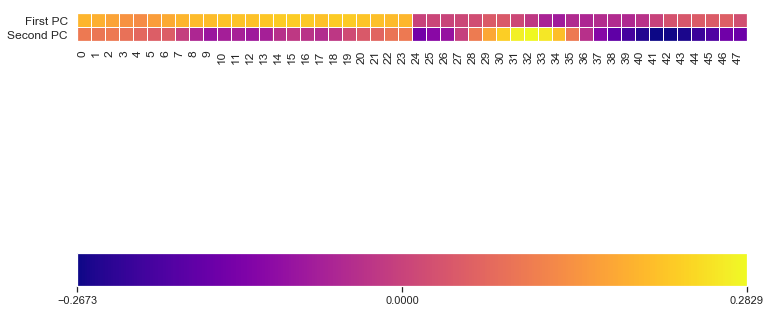

In [19]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')

plt.gca().set_xticks(np.arange(-.5, 48))
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

In [20]:
print('First PCA mean norm and std dev of hourly activity coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[0][:24]).mean(),np.absolute(pca.components_[0][:24]).std()))
print('First PCA mean norm and std dev of hourly flux coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[0][24:]).mean(),np.absolute(pca.components_[0][24:]).std()))

print('Second PCA mean norm and std dev of hourly activity coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[1][:24]).mean(),np.absolute(pca.components_[1][:24]).std()))
print('Second PCA mean norm and std dev hourly flux coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[1][24:]).mean(),np.absolute(pca.components_[1][24:]).std()))


First PCA mean norm and std dev of hourly activity coefficient: 0.199, 0.025
First PCA mean norm and std dev of hourly flux coefficient: 0.033, 0.020
Second PCA mean norm and std dev of hourly activity coefficient: 0.060, 0.028
Second PCA mean norm and std dev hourly flux coefficient: 0.177, 0.076


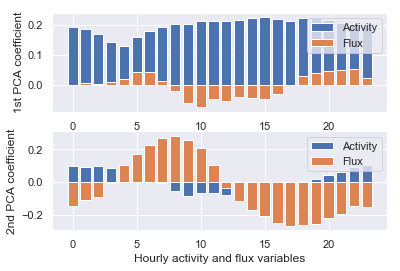

In [21]:
#Another visualization of the PCA components
fig,ax = plt.subplots(2)

ax[0].bar(range(24),pca.components_[0][:24])
ax[0].bar(range(24),pca.components_[0][24:])
ax[0].set_xlabel('Hourly activity and flux variables')
ax[0].set_ylabel('1st PCA coefficient')

ax[0].legend(['Activity','Flux'])

ax[1].bar(range(24),pca.components_[1][:24])
ax[1].bar(range(24),pca.components_[1][24:])
ax[1].set_xlabel('Hourly activity and flux variables')
ax[1].set_ylabel('2nd PCA coefficient')

ax[1].legend(['Activity','Flux'])

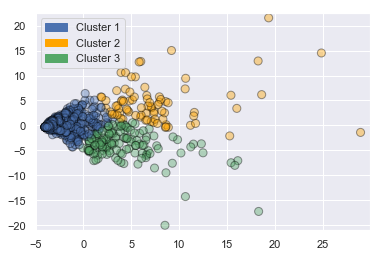

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_pca)

WD_counts_df['Kmeans_label'] = kmeans.labels_

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

In [27]:
flux_df=WD_counts_df[['Flux','Kmeans_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
flux_melt_df = flux_df.iloc[0:24].melt('hour', var_name='station', value_name='flux')
flux_melt_df['Kmeans_label']=flux_melt_df['station'].map(lambda x: flux_df.iloc[24][x])

In [28]:
flux_melt_df['Kmeans_label']=flux_melt_df['Kmeans_label'].astype(int)

In [29]:
flux_melt_df.head()

hour station  flux  Kmeans_label
0    0      72   0.0             0
1    1      72   1.0             0
2    2      72   6.0             0
3    3      72   1.0             0
4    4      72   2.0             0

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


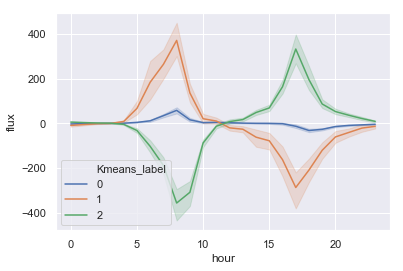

In [30]:
#Using Flux 
sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="flux", hue = 'Kmeans_label', palette = sns.color_palette(n_colors=3),data=flux_melt_df)

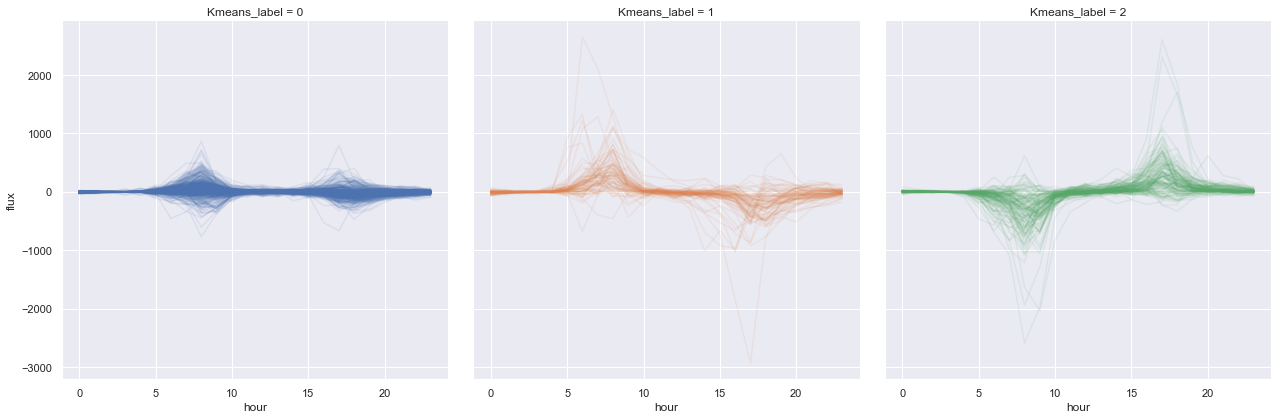

In [31]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

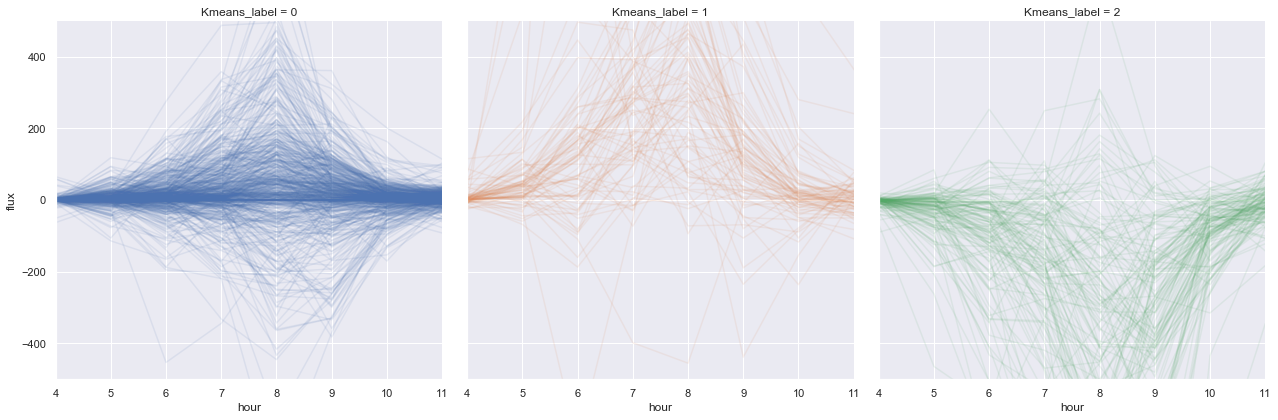

In [32]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', height=6,col_wrap=3)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=4,right=11);

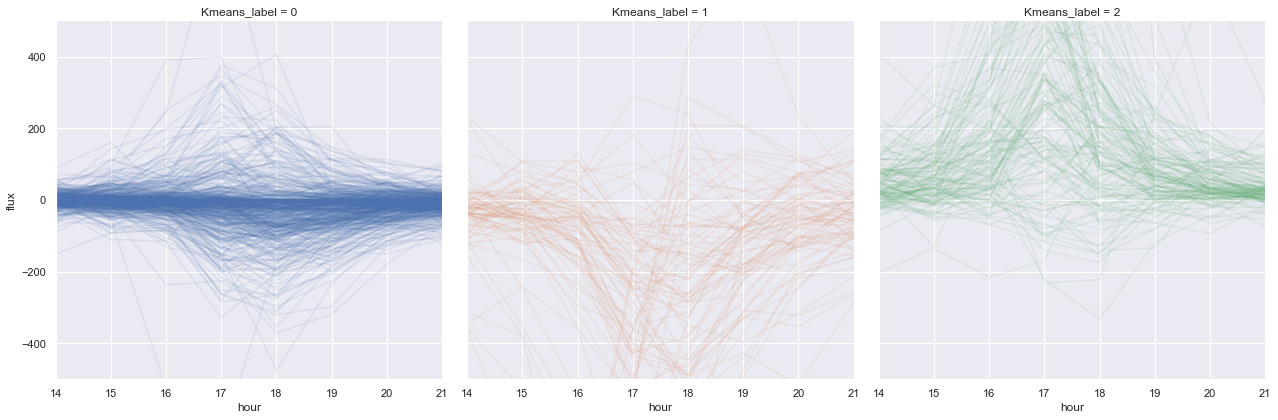

In [33]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', height=6,col_wrap = 3)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=14,right=21);

Plotting Activity

In [34]:
activity_df=WD_counts_df[['Activity','Kmeans_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
activity_melt_df = activity_df.iloc[0:24].melt('hour', var_name='station', value_name='activity')
activity_melt_df['Kmeans_label']=activity_melt_df['station'].map(lambda x: activity_df.iloc[24][x])

In [35]:
activity_melt_df['Kmeans_label']=activity_melt_df['Kmeans_label'].astype(int)

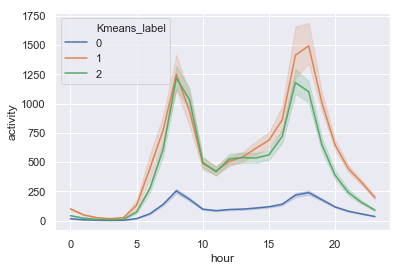

In [36]:
sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="activity", hue = 'Kmeans_label', palette = sns.color_palette(n_colors=3),data=activity_melt_df)

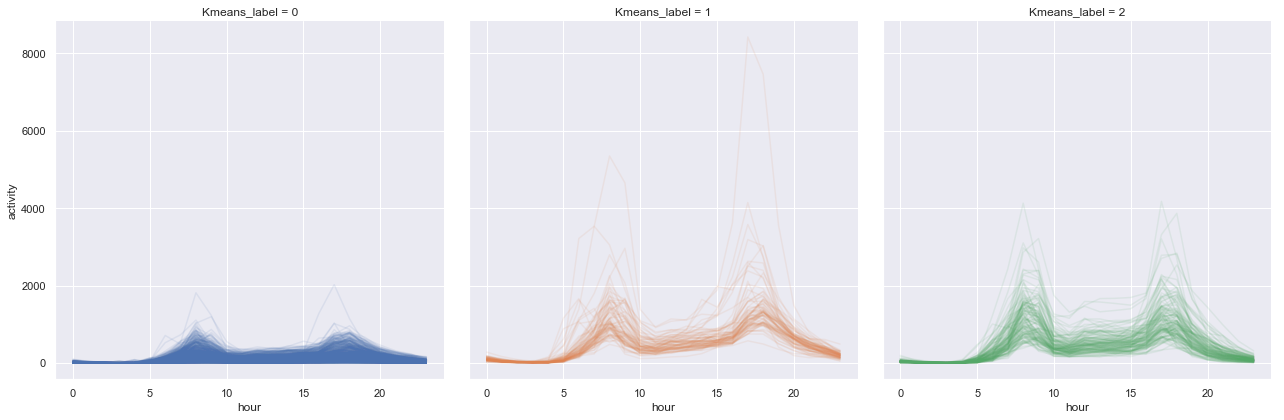

In [37]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(activity_melt_df,col='Kmeans_label',hue='Kmeans_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','activity', estimator = None, units='station',alpha=.1)

In [55]:
for num in len(np.unique(kmeans.labels_)):
    print('Kmeans_label {}: {}'.format(num,len(WD_counts_df[WD_counts_df['Kmeans_label'] == num])))

Kmeans_label 0: 564
Kmeans_label 1: 80
Kmeans_label 2: 133


In [38]:
stations_info_df['Kmeans_label'] = WD_counts_df['Kmeans_label']
stations_info_df['color'] = stations_info_df['Kmeans_label'].map(lambda x: color_st(x))

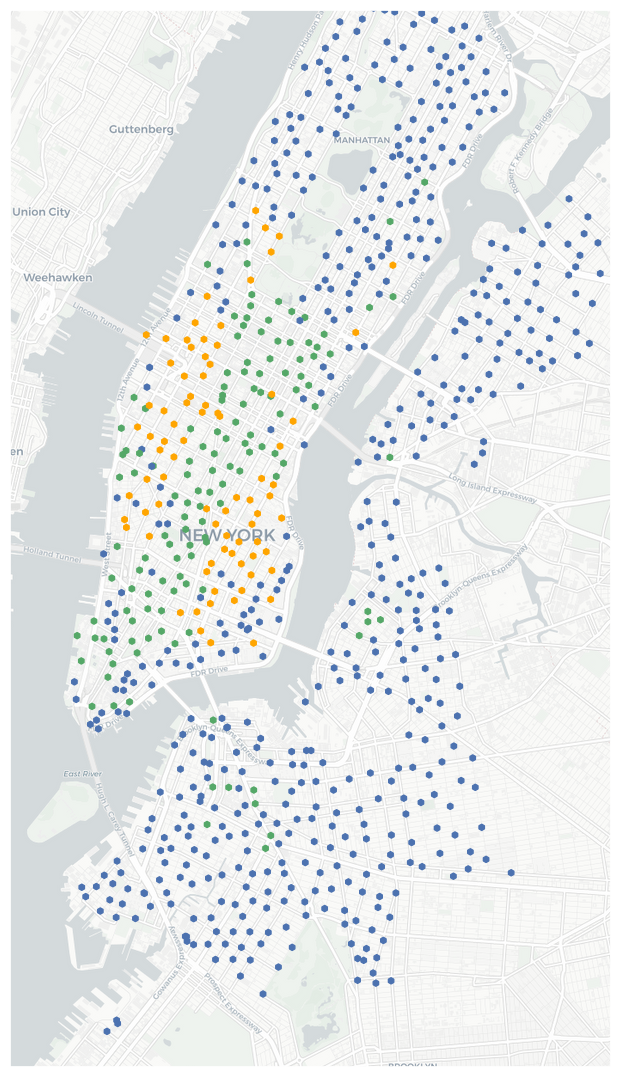

In [39]:
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)

## Now using 4 clusters

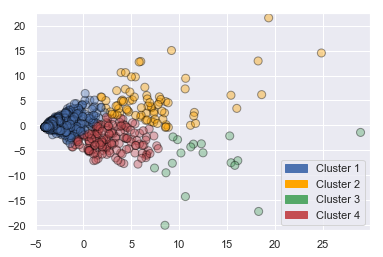

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'])

In [41]:
WD_counts_df['Kmeans4_label'] = kmeans.labels_

Plotting Flux

In [42]:
flux_4cluster_df=WD_counts_df[['Flux','Kmeans4_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
flux_4cluster_melt_df = flux_4cluster_df.iloc[0:24].melt('hour', var_name='station', value_name='flux')
flux_4cluster_melt_df['Kmeans4_label']=flux_4cluster_melt_df['station'].map(lambda x: flux_4cluster_df.iloc[24][x])

In [43]:
flux_4cluster_melt_df['Kmeans4_label']=flux_4cluster_melt_df['Kmeans4_label'].astype(int)

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


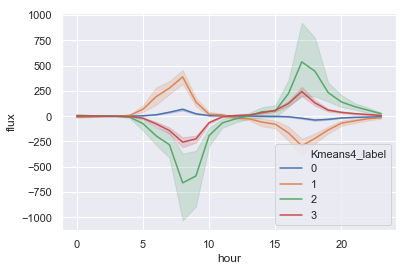

In [44]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.color_palette()

ax = sns.lineplot(x="hour", y="flux", hue = 'Kmeans4_label', palette = sns.color_palette(n_colors = 4), data=flux_4cluster_melt_df)

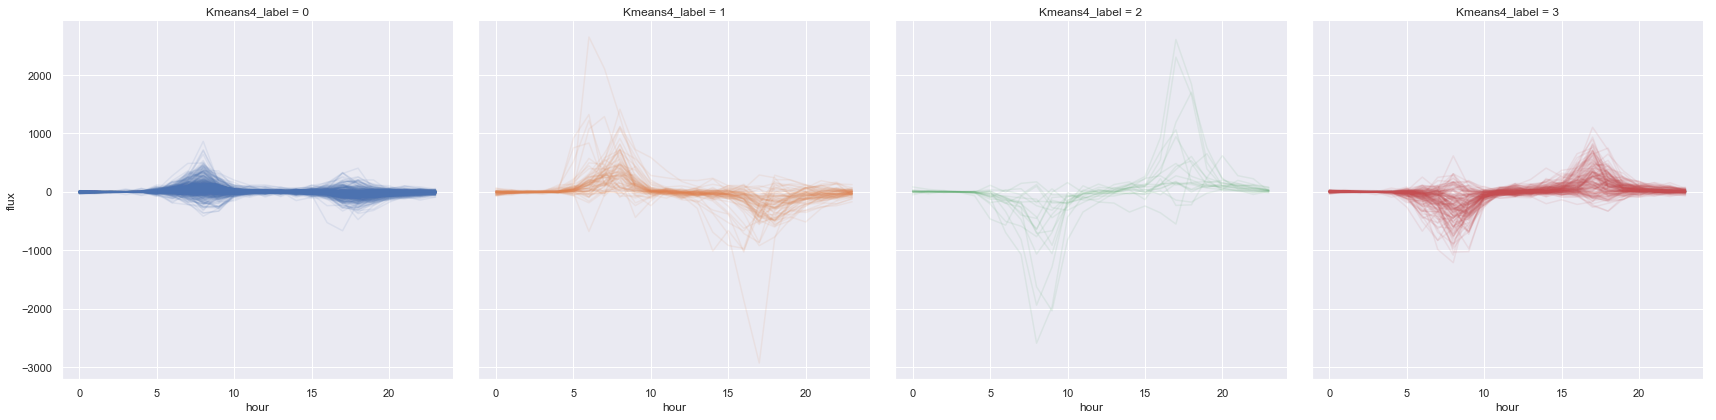

In [45]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

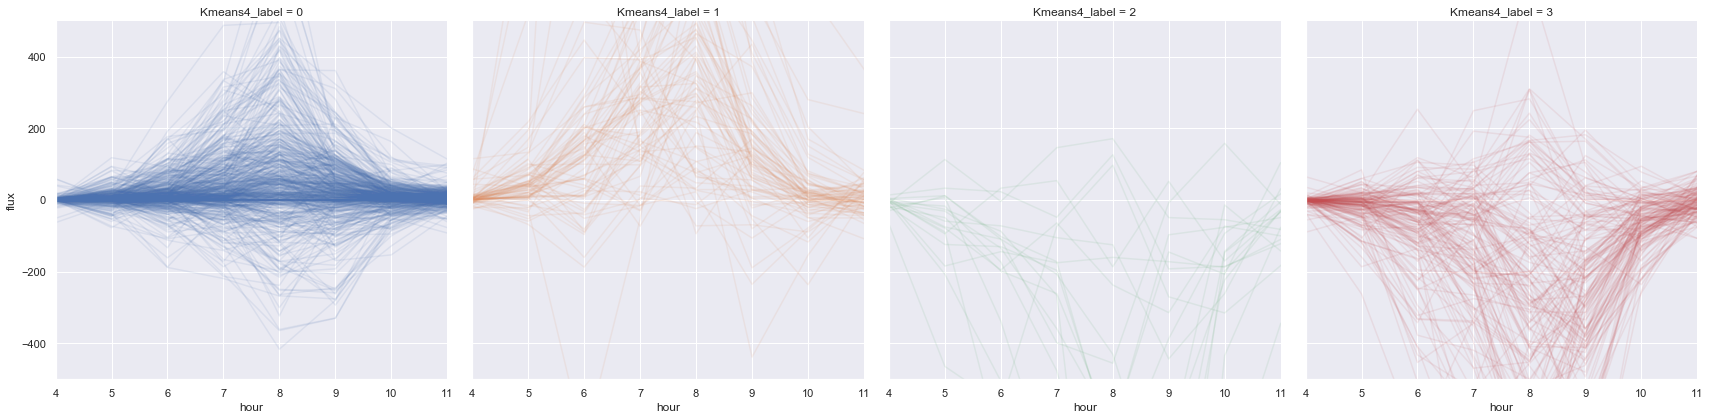

In [46]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=4,right=11);

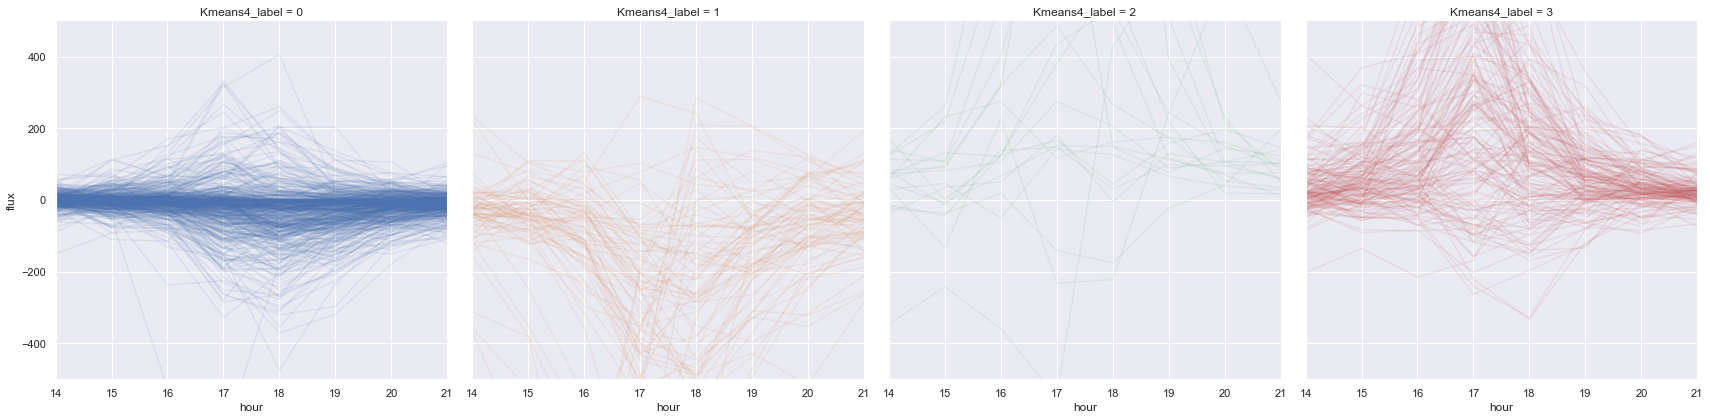

In [47]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=14,right=21);

Plotting Activity

In [48]:
activity_4cluster_df=WD_counts_df[['Activity','Kmeans4_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
activity_4cluster_melt_df = activity_4cluster_df.iloc[0:24].melt('hour', var_name='station', value_name='activity')
activity_4cluster_melt_df['Kmeans4_label']=activity_4cluster_melt_df['station'].map(lambda x: activity_4cluster_df.iloc[24][x])

In [49]:
activity_4cluster_melt_df['Kmeans4_label']=activity_4cluster_melt_df['Kmeans4_label'].astype(int)

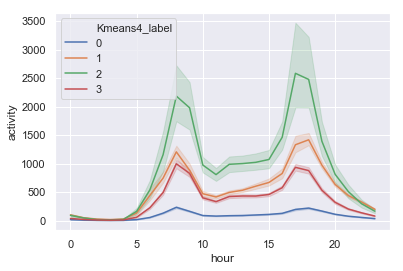

In [50]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="activity", hue = 'Kmeans4_label', palette= sns.color_palette(n_colors=4), data=activity_4cluster_melt_df)


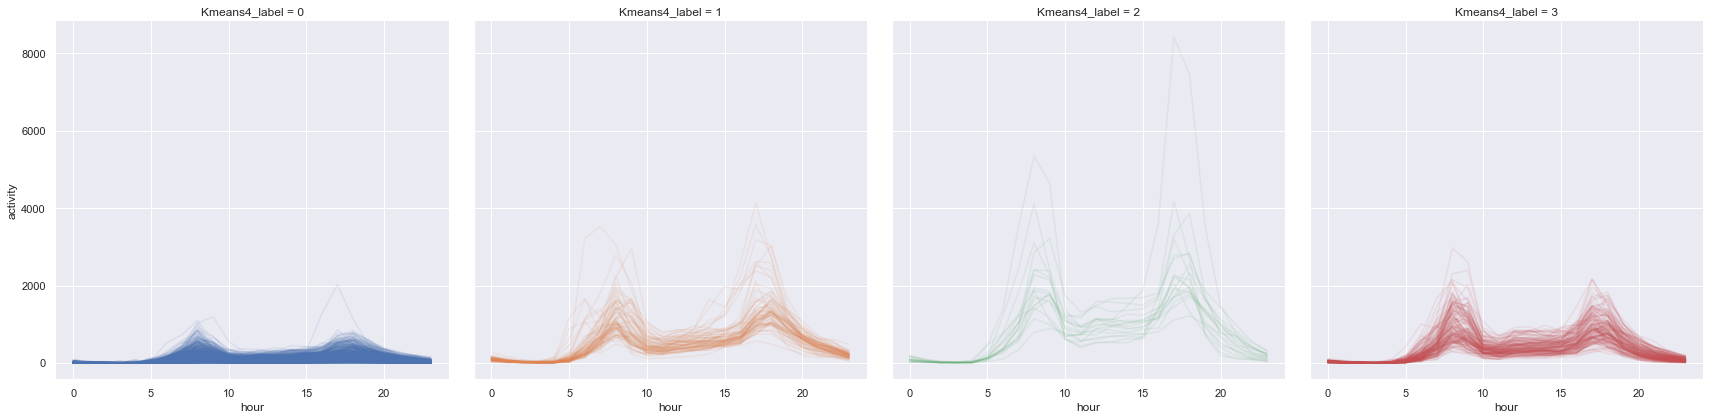

In [51]:
#Plot all stations
sns.set(font_scale=1)

g = sns.FacetGrid(activity_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap=4)
g = g.map_dataframe(sns.lineplot, 'hour','activity', estimator = None, units='station',alpha=.1)

In [52]:
for num in range(len(np.unique(kmeans.labels_))):
    print('Kmeans4_label {}: {}'.format(num,len(WD_counts_df[WD_counts_df['Kmeans4_label'] == num])))

Kmeans4_label 0: 531
Kmeans4_label 1: 76
Kmeans4_label 2: 18
Kmeans4_label 3: 152


In [53]:
stations_info_df['Kmeans4_label'] = WD_counts_df['Kmeans4_label']
stations_info_df['color'] = stations_info_df['Kmeans4_label'].map(lambda x: color_st(x))

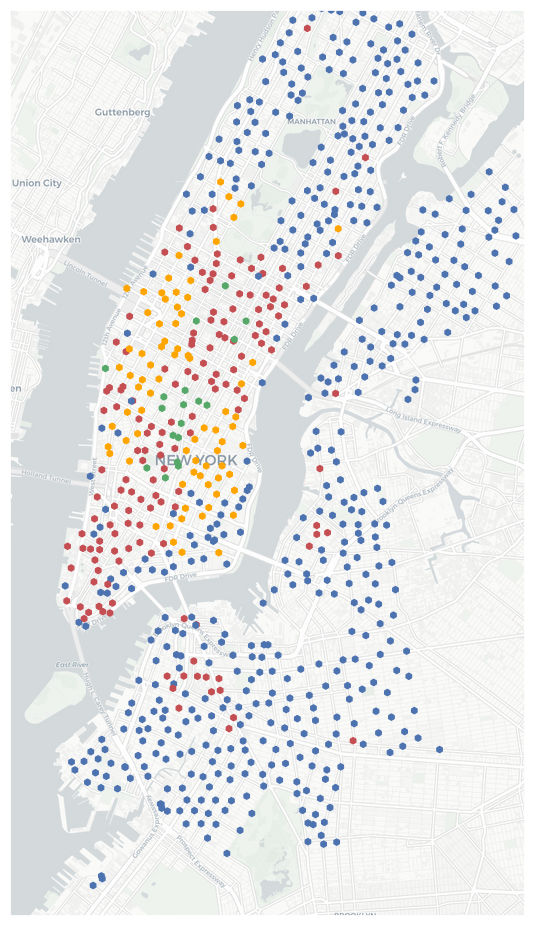

In [54]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);
   